In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import math
import seaborn as sns
import impyute as impy

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [4]:
cleaned_dataset = pd.read_csv('cleaned_dataset.csv')

In [5]:
# drop cloumn Unnamed: 0

# Fixing date column datatype
cleaned_dataset['date'] = pd.to_datetime(cleaned_dataset['date']);
# all_countries_dataset['location'] = all_countries_dataset['location'].astype('category');
# all_countries_dataset['continent'] = all_countries_dataset['continent'].astype('category');

# all_countries_dataset.set_index('date', inplace=True)

In [6]:
# take only numerical variables
numerical_variables = [
    'new_cases',
    'new_deaths',
    'icu_patients',
    'new_tests',
    'positive_rate',
    'people_vaccinated',
    'new_vaccinations',
    'total_boosters',
    'stringency_index'
]

# take non-numerical variables
non_numerical_variables = [
    'continent',
    'location',
    'date'
]

svr_dataset = cleaned_dataset.copy()

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

obj_dataset = svr_dataset[non_numerical_variables].copy()
num_dataset = svr_dataset[numerical_variables].copy()
# num_dataset = sc.fit_transform(num_dataset)

num_dataset = pd.DataFrame(num_dataset, columns=numerical_variables)


num_dataset = np.log(num_dataset)

# Take First Difference to Remove Trend
num_dataset = num_dataset.diff()

num_dataset = num_dataset.diff()

# Remove Increasing Volatility
# num_dataset = num_dataset.groupby(num_dataset.index.year).std()

svr_dataset = pd.concat([obj_dataset, pd.DataFrame(data=num_dataset, columns=numerical_variables)], axis=1)

svr_dataset.dtypes

continent                    object
location                     object
date                 datetime64[ns]
new_cases                   float64
new_deaths                  float64
icu_patients                float64
new_tests                   float64
positive_rate               float64
people_vaccinated           float64
new_vaccinations            float64
total_boosters              float64
stringency_index            float64
dtype: object

In [7]:
svr_dataset.index = pd.to_datetime(svr_dataset.date)
svr_dataset.index.freq = svr_dataset.index.inferred_freq

In [8]:
def replace_nans(dataset):
    # for each country
    new_dataset = pd.DataFrame()

    for country in dataset['location'].unique():
        country_dataset = dataset[dataset['location'] == country]

        for variable in numerical_variables:
            for index, row in country_dataset.iterrows():
                if pd.isna(row[variable]) or row[variable] == float('inf') or row[variable] == float('-inf'):
                    previous_timestamp = index - pd.Timedelta(days=1)
                    if previous_timestamp in country_dataset.index and pd.isna(country_dataset.loc[previous_timestamp, variable]) == False:
                        country_dataset.at[index, variable] = country_dataset.at[previous_timestamp, variable]
                    else:
                        country_dataset.at[index, variable] = 0
    
        new_dataset = pd.concat([new_dataset, country_dataset], axis=0)

    return new_dataset

In [9]:
svr_dataset = replace_nans(svr_dataset)

### Add lags

In [10]:
nb_lags_dependent = 1 # calculated with AutoARIMA
nb_lags_independent = 1 # calculated with AutoARIMA

vars_to_lag = [
    'icu_patients',
    'new_tests',
    'new_vaccinations'
]

# for each variable
for variable in vars_to_lag:
    if variable == 'new_deaths':
        continue
    for nb_lag in range(0, nb_lags_independent):
        svr_dataset[variable + '_' + str(nb_lag)] = svr_dataset[variable].shift(nb_lag)

for nb_lag in range(nb_lags_dependent):
    svr_dataset['new_deaths_' + str(nb_lag)] = svr_dataset['new_deaths'].shift(nb_lag)

In [11]:
# remove nan values created by shift()
svr_dataset = svr_dataset.dropna()

In [12]:
print(svr_dataset.columns.tolist())
numerical_variables_with_lags = svr_dataset.columns.tolist()
# exclude non_numerical_variables from numerical_variables_with_lags
numerical_variables_with_lags = [x for x in numerical_variables_with_lags if x not in non_numerical_variables]

['continent', 'location', 'date', 'new_cases', 'new_deaths', 'icu_patients', 'new_tests', 'positive_rate', 'people_vaccinated', 'new_vaccinations', 'total_boosters', 'stringency_index', 'icu_patients_0', 'new_tests_0', 'new_vaccinations_0', 'new_deaths_0']


### Add dummy variables

In [13]:
countries = svr_dataset['location'].unique()

In [14]:
# for each country
for country in svr_dataset['location'].unique():
    # set empty column with 0 values for svr_dataset[country]
    svr_dataset[country] = 0
    svr_dataset[country].loc[svr_dataset['location'] == country] = 1

# drop location column
svr_dataset = svr_dataset.drop(columns=['location'])
# drop continent column
svr_dataset = svr_dataset.drop(columns=['continent'])

/home/ion/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [15]:
# split into train and test
# training_date_limit = date(2021, 10, 15)

# svr_dataset.index = pd.to_datetime(svr_dataset.date)
# svr_dataset.index.freq = svr_dataset.index.inferred_freq

# svr_train_dataset = svr_dataset[svr_dataset['date'].dt.date < training_date_limit]
# svr_test_dataset = svr_dataset[svr_dataset['date'].dt.date >= training_date_limit]

In [16]:
# find max date
max_date = svr_dataset['date'].max()
min_date = svr_dataset['date'].min()
print(min_date)
print(max_date)

2020-01-06 00:00:00
2021-11-01 00:00:00


In [17]:
# import SVR
from sklearn.svm import SVR


def svr(svr_train_dataset):
    y = svr_train_dataset['new_deaths']
    
    X = svr_train_dataset[numerical_variables_with_lags]
    
    for numercal_variable in numerical_variables:
        X = X.drop(columns=numercal_variable)

    svr_model = SVR()
    svr_model.fit(X, y)

    return svr_model

In [18]:
def svr_predict(model, country, svr_test_dataset, plot):
    y_test = svr_test_dataset['new_deaths'].loc[svr_test_dataset[country] == 1]

    # show score
    X_test = svr_test_dataset[numerical_variables_with_lags].loc[svr_test_dataset[country] == 1]
    
    for numerical_variable in numerical_variables:
        X_test = X_test.drop(columns=numerical_variable)
    
    predictions = model.predict(X_test)

    print("Country: {} - C: {} - SVR Score: {}".format(country, model.C, model.score(X_test, y_test)))
 
    if plot:
        # plot predictions vs actual
        plt.figure(figsize=(10, 5))
        plt.plot(svr_test_dataset['date'].loc[svr_test_dataset[country] == 1], predictions, label='Predictions')
        plt.plot(svr_test_dataset['date'].loc[svr_test_dataset[country] == 1], y_test, label='Actual')
        plt.xlabel("Date")
        plt.ylabel("New Deaths")
        plt.title(country)
        plt.legend()
        plt.show()

    return predictions

### Cross-Fold validation

=========================================================== Data taken from 2020-01-06 00:00:00 to 2020-05-05 00:00:00
(3088, 55)
DatetimeIndex(['2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28',
               '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03',
               '2020-03-04', '2020-03-05',
               ...
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
               '2020-04-13', '2020-04-14'],
              dtype='datetime64[ns]', name='date', length=2268, freq=None)
DatetimeIndex(['2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18',
               '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22',
               '2020-04-23', '2020-04-24',
               ...
               '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28',
               '2020-04-29', '2020-04-30', '2020-05-01', '2020-05-02',
               '2020-05-03', '2020-05-04'],
              d

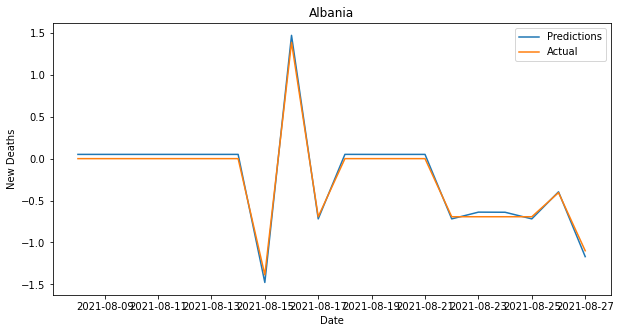

Country: Austria - C: 1.0 - SVR Score: 0.9969791070063942


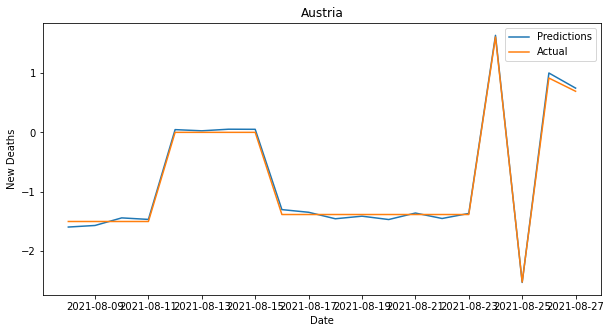

Country: Belarus - C: 1.0 - SVR Score: 0.9012613723424504


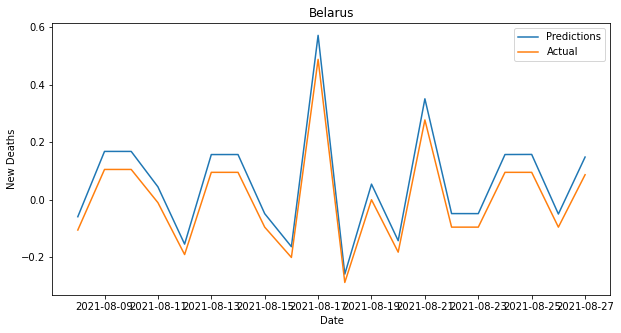

Country: Belgium - C: 1.0 - SVR Score: 0.9979706030579439


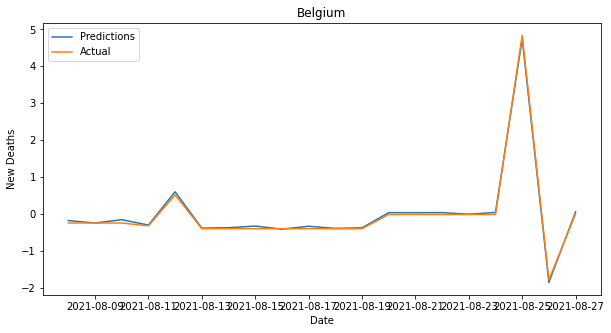

Country: Bosnia and Herzegovina - C: 1.0 - SVR Score: 0.9929521031787878


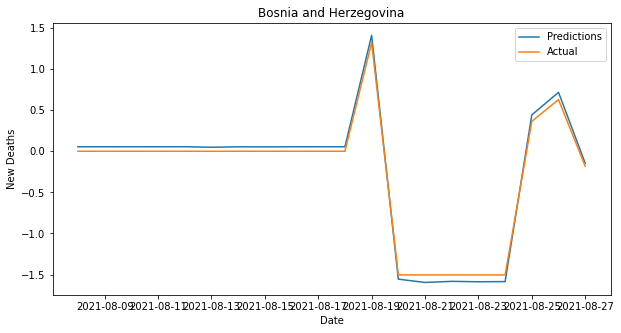

Country: Bulgaria - C: 1.0 - SVR Score: 0.9984242096372345


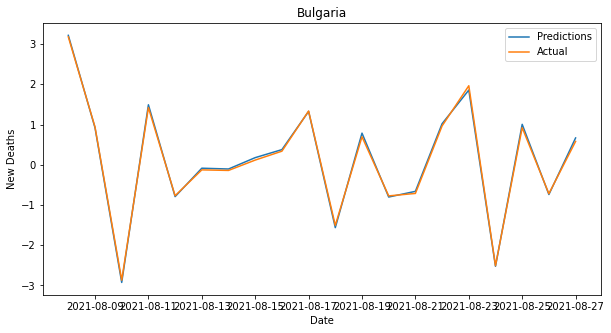

Country: Croatia - C: 1.0 - SVR Score: 0.9957577005450242


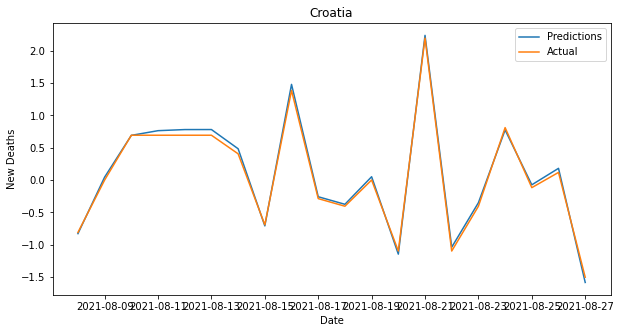

Country: Cyprus - C: 1.0 - SVR Score: 0.99595964635302


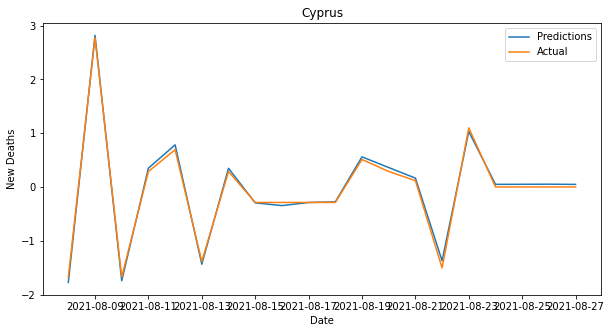

Country: Czechia - C: 1.0 - SVR Score: 0.9950475715592547


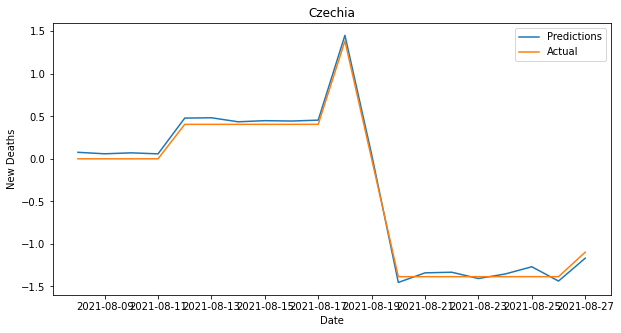

Country: Denmark - C: 1.0 - SVR Score: 0.9948406666673143


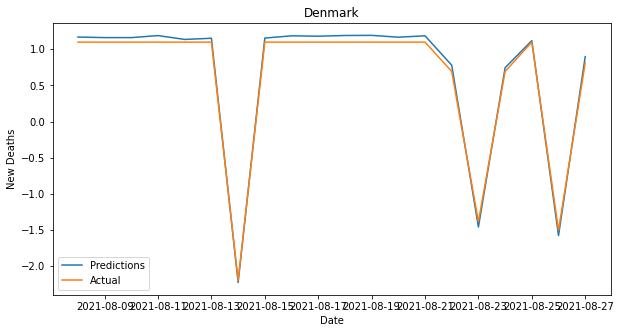

Country: Estonia - C: 1.0 - SVR Score: 0.0


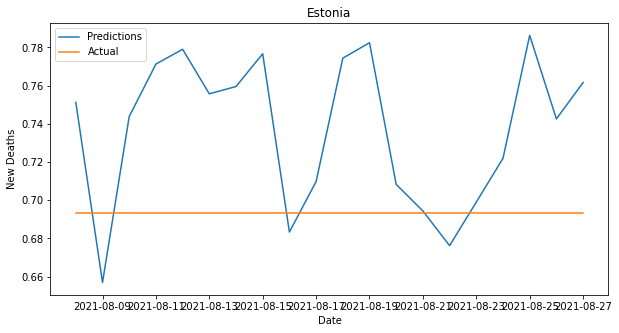

Country: Finland - C: 1.0 - SVR Score: 0.9979739381106743


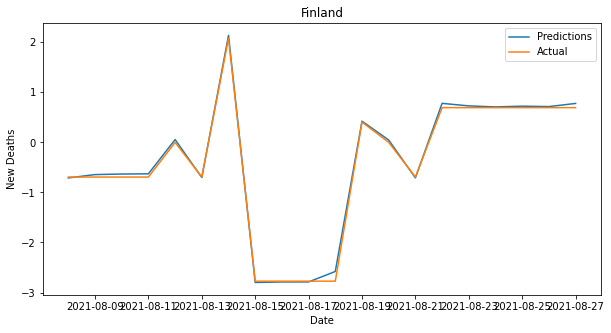

Country: France - C: 1.0 - SVR Score: 0.9910416704108164


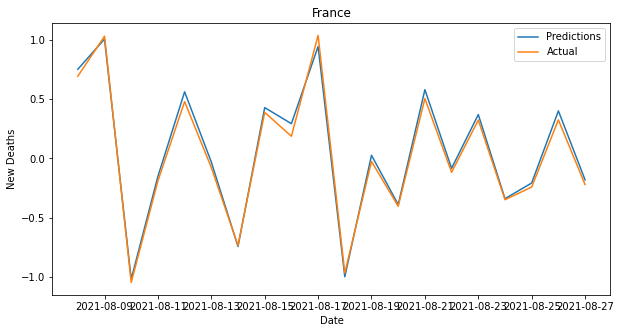

Country: Germany - C: 1.0 - SVR Score: 0.9986651495742555


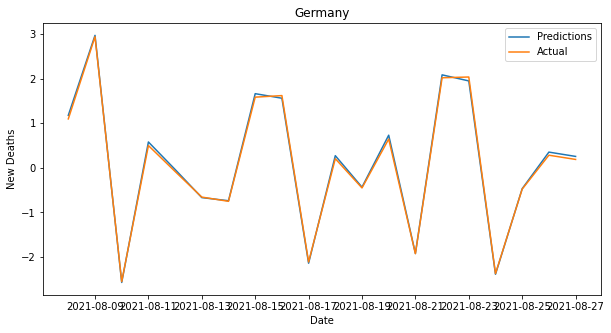

Country: Greece - C: 1.0 - SVR Score: 0.9498283148983551


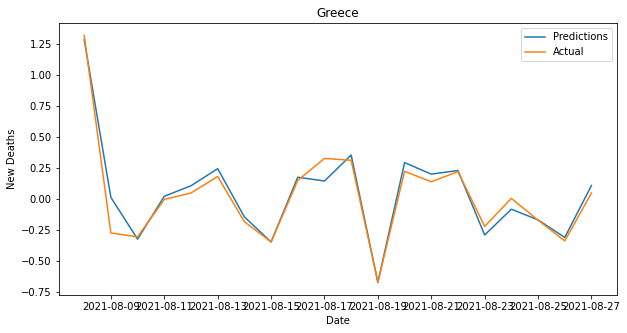

Country: Hungary - C: 1.0 - SVR Score: 0.9991296619674332


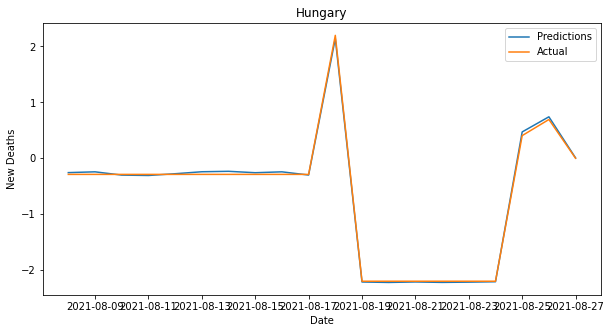

Country: Ireland - C: 1.0 - SVR Score: -5.752422042067382e+27


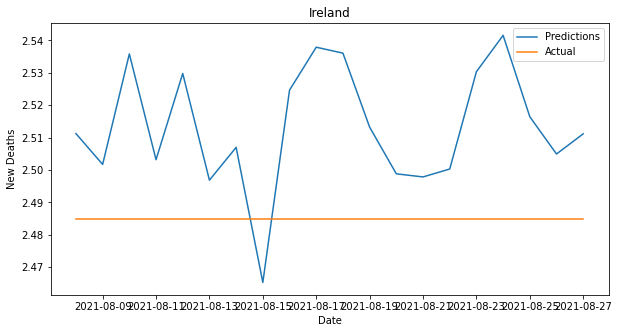

Country: Italy - C: 1.0 - SVR Score: 0.9957310220678284


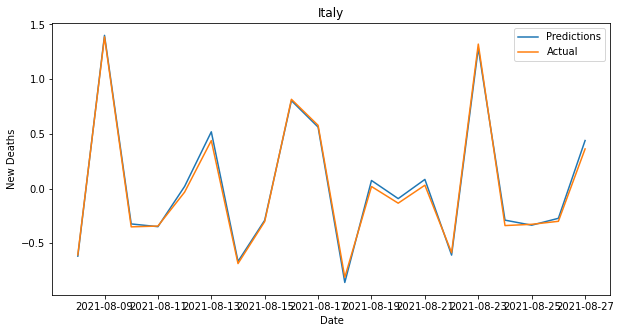

Country: Kosovo - C: 1.0 - SVR Score: 0.99710098782125


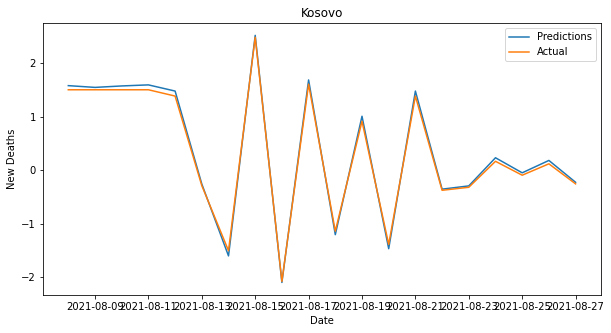

Country: Latvia - C: 1.0 - SVR Score: 0.9829225912238094


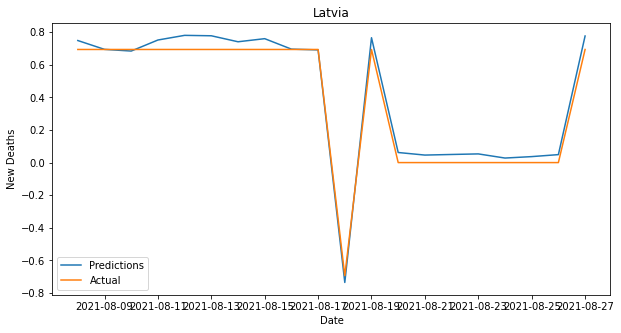

Country: Lithuania - C: 1.0 - SVR Score: 0.9852447419237911


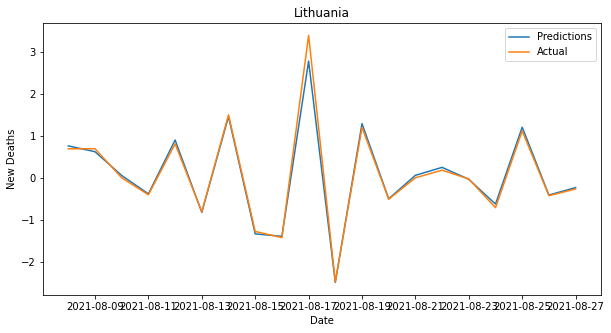

Country: Luxembourg - C: 1.0 - SVR Score: 0.0


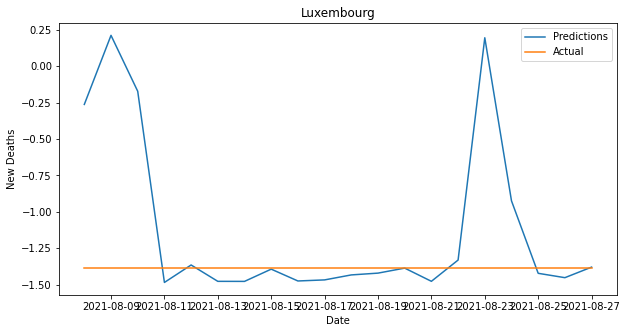

Country: Malta - C: 1.0 - SVR Score: 0.0


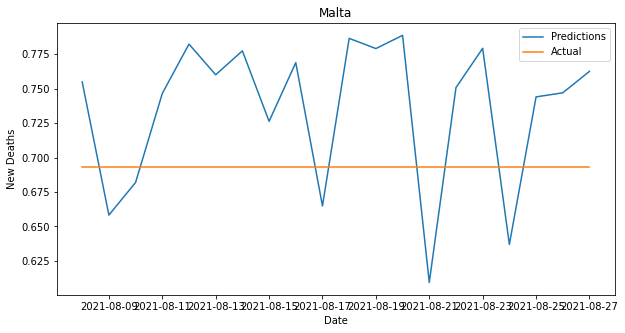

Country: Moldova - C: 1.0 - SVR Score: 0.9680529526245214


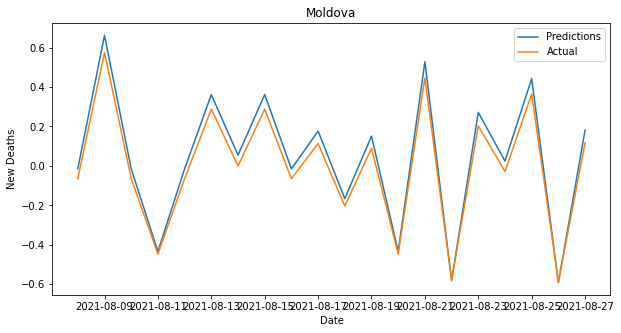

Country: Montenegro - C: 1.0 - SVR Score: 0.9971271365656798


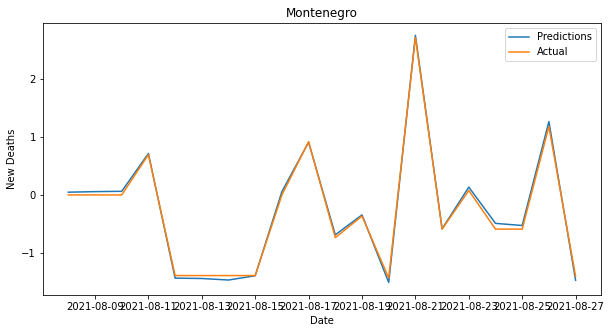

Country: Netherlands - C: 1.0 - SVR Score: 0.99458535120585


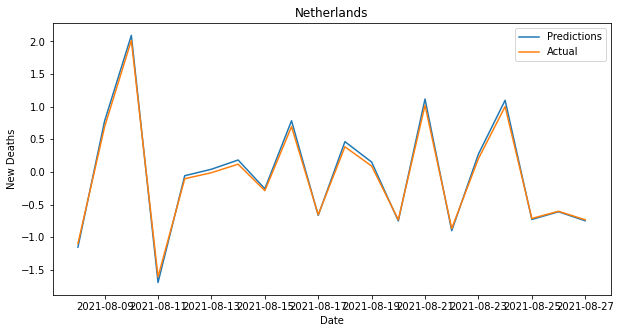

Country: North Macedonia - C: 1.0 - SVR Score: 0.9941245128159256


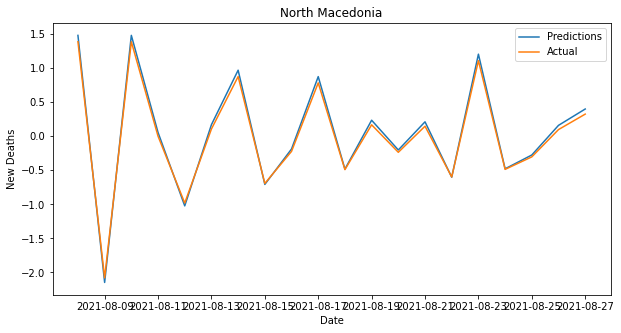

Country: Norway - C: 1.0 - SVR Score: 0.9982119967062965


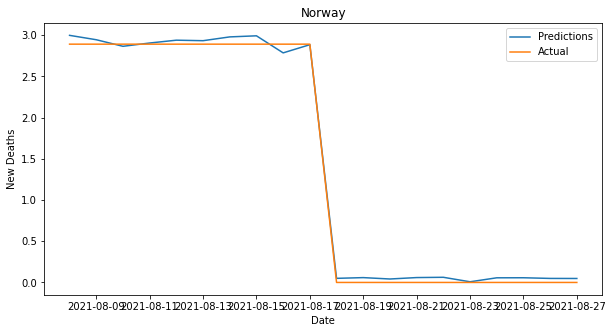

Country: Poland - C: 1.0 - SVR Score: 0.9982767472675032


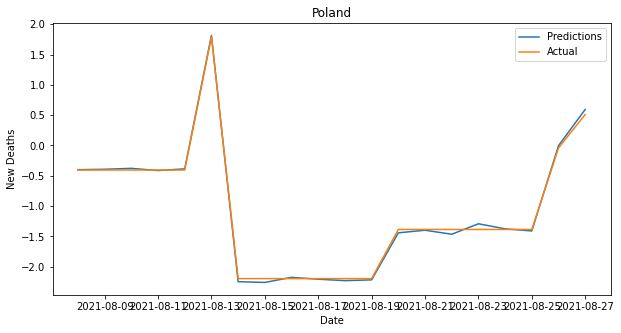

Country: Portugal - C: 1.0 - SVR Score: 0.9927756070841552


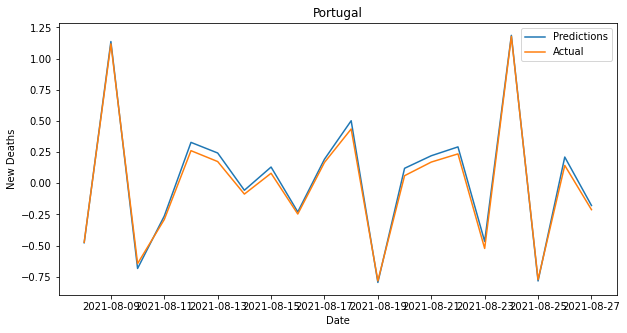

Country: Romania - C: 1.0 - SVR Score: 0.9928505555626549


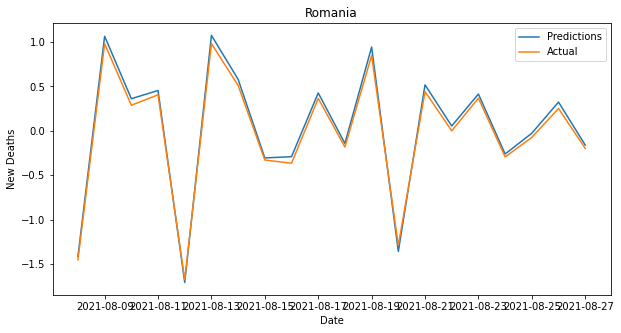

Country: Russia - C: 1.0 - SVR Score: -4.374769807184144


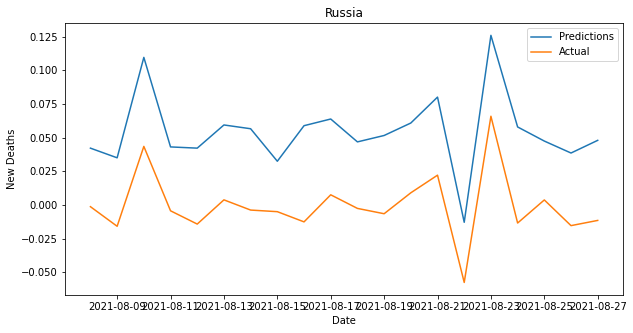

Country: Serbia - C: 1.0 - SVR Score: 0.9976532515848674


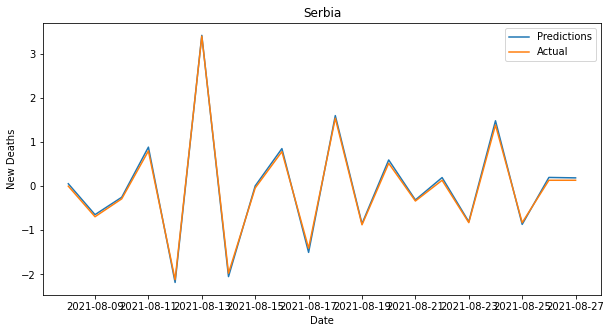

Country: Slovakia - C: 1.0 - SVR Score: 0.0


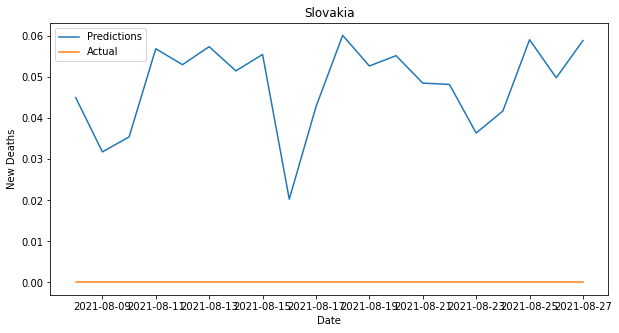

Country: Slovenia - C: 1.0 - SVR Score: 0.9054246815192369


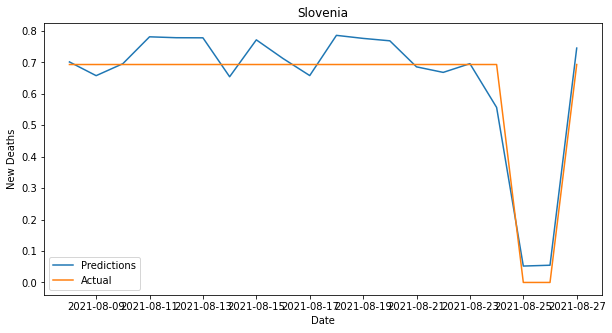

Country: Spain - C: 1.0 - SVR Score: 0.9549620941300501


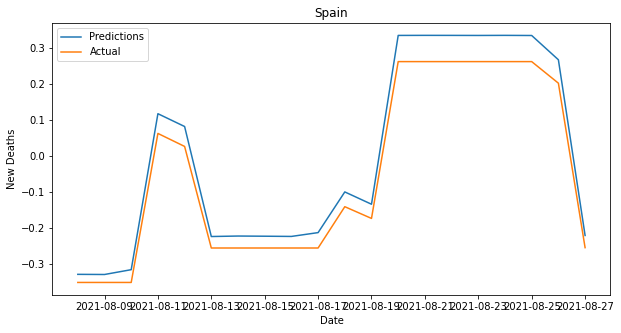

Country: Sweden - C: 1.0 - SVR Score: 0.9925804467917325


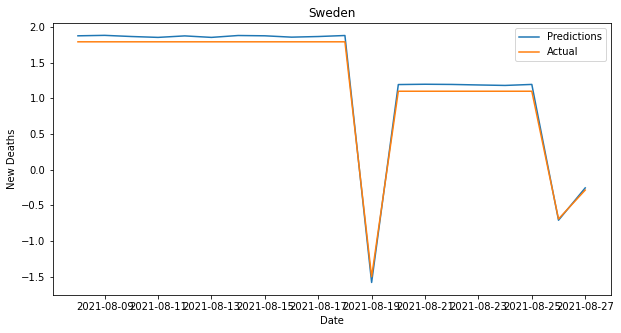

Country: Switzerland - C: 1.0 - SVR Score: 0.9943997108195802


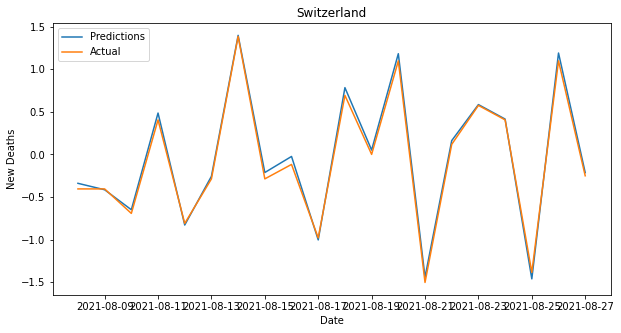

Country: Ukraine - C: 1.0 - SVR Score: 0.9923017206576061


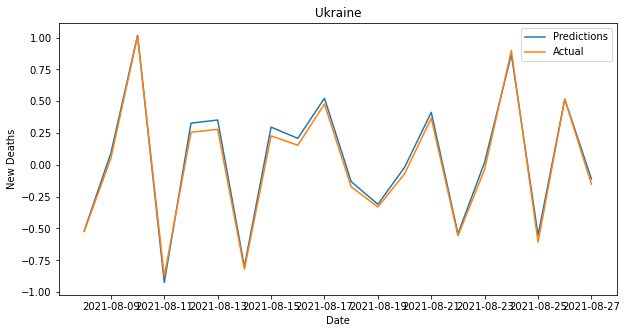

Country: United Kingdom - C: 1.0 - SVR Score: 0.9952078950089773


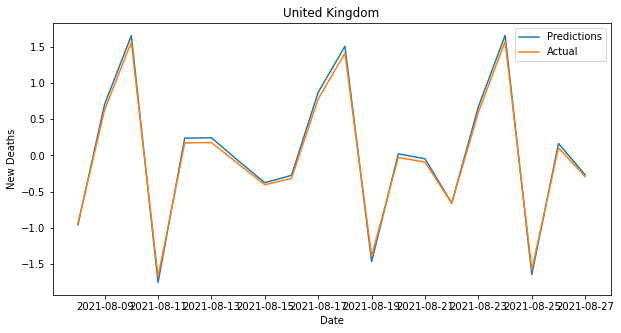

Country: United States - C: 1.0 - SVR Score: 0.998182430390563


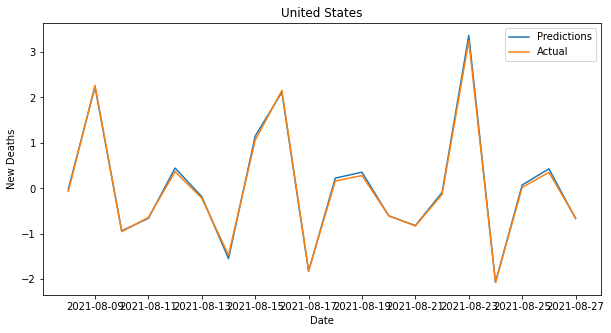

In [19]:
index = min_date + pd.Timedelta(days=120)

while index <= max_date:
    print("=========================================================== Data taken from {} to {}".format(min_date, index))

    # get data where svr_dataset.index < index
    df = svr_dataset[svr_dataset.index < index]
    df.index = pd.to_datetime(df.date)
    print(df.shape)


    # extract 20 from index
    threashold = index - pd.Timedelta(days=20)

    svr_train_dataset = df[df.index < threashold]
    svr_test_dataset = df[df.index >= threashold]

    print(svr_train_dataset.index)
    print(svr_test_dataset.index)

    model = svr(svr_train_dataset)
    # for each country
    for country in countries:
        plot = False
        if index + pd.Timedelta(days=120) > max_date:
            plot = True
        svr_predict(model, country, svr_test_dataset, plot)

    index = index + pd.Timedelta(days=120)
